<a href="https://colab.research.google.com/github/vimesh630/Automated-Image-Caption-Generator/blob/main/CNN_to_Classification(with_ResNet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connect Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries & Set Paths

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set parameters and paths
SPLIT_DATASET_PATH = '/content/drive/MyDrive/DSGP/Splitted_Dataset'
MODEL_SAVE_PATH = '/content/drive/MyDrive/DSGP/resnet_model.keras'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
EPOCHS = 10

Create Data Generators

In [3]:
def load_datasets(split_dataset_path, batch_size, img_size):
    TRAIN_DIR = os.path.join(split_dataset_path, 'train')
    VAL_DIR   = os.path.join(split_dataset_path, 'val')
    TEST_DIR  = os.path.join(split_dataset_path, 'test')

    # Load raw training dataset to capture class names
    raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        color_mode='rgb'
    )
    class_names = raw_train_dataset.class_names
    print("Classes:", class_names)

    # Load raw validation and test datasets
    raw_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DIR,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        color_mode='rgb'
    )
    raw_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR,
        label_mode='categorical',
        batch_size=batch_size,
        image_size=img_size,
        color_mode='rgb',
        shuffle=False  # Keep order for evaluation
    )

    # Optimize dataset pipeline with caching and prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = raw_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    val_dataset = raw_val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    test_dataset = raw_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    return train_dataset, val_dataset, test_dataset, class_names

Build & Compile the CNN Model

In [4]:
def build_resnet_model(img_size, num_classes, fine_tune=False):
    # Load ResNet50 as the base model with pretrained ImageNet weights, exclude top layers
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size[0], img_size[1], 3))
    base_model.trainable = False  # Freeze base model initially

    # Build custom classification head with data augmentation layers
    inputs = Input(shape=(img_size[0], img_size[1], 3))
    # Data augmentation: Randomly flip and rotate images to improve generalization
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    # Preprocess input for ResNet50
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    if fine_tune:
        base_model.trainable = True
        # Freeze all layers except the top 20 layers of the base model
        for layer in base_model.layers[:-20]:
            layer.trainable = False
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        print("Base model partially unfrozen for fine-tuning.")
    return model

Train & Save the Model

In [5]:
def train_model(model, train_dataset, val_dataset, epochs):
    # Add callbacks for early stopping and reducing learning rate on plateau
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=callbacks
    )
    return history

def save_model_keras(model, model_save_path):
    model.save(model_save_path)
    print("Model saved successfully at:", model_save_path)

Plot Training History

In [6]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

Evaluate the Model

In [7]:
def evaluate_model(model, test_dataset, class_names):
    predictions = model.predict(test_dataset, verbose=1)
    predicted_labels = np.argmax(predictions, axis=1)

    # Extract true labels from the test dataset
    true_labels = []
    for images, labels in test_dataset:
        true_labels.extend(np.argmax(labels.numpy(), axis=1))
    true_labels = np.array(true_labels)

    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=class_names))

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Main Execution

Found 25600 files belonging to 16 classes.
Classes: ['astrocitoma', 'carcinoma', 'ependimoma', 'ganglioglioma', 'germinoma', 'glioblastoma', 'granuloma', 'meduloblastoma', 'meningioma', 'neurocitoma', 'no_tumour', 'oligodendroglioma', 'papiloma', 'pituitary', 'schwannoma', 'tuberculoma']
Found 3200 files belonging to 16 classes.
Found 3200 files belonging to 16 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip_1             │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_1         │ (None, 224, 224, 3)    │              0 │ random_flip_1[0][0]    │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 224, 224)       │              0 │ random_rotation_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 224, 224)       │              0 │ random_rotation_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 224, 224)       │              0 │ random_rotation_1[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_1 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │         32,784 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,620,496 (90.11 MB)

 Trainable params: 32,784 (128.06 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 117s 138ms/step - accuracy: 0.4455 - loss: 1.9314 - val_accuracy: 0.7009 - val_loss: 0.9203 - learning_rate: 0.0010
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7191 - loss: 0.8901 - val_accuracy: 0.7550 - val_loss: 0.7766 - learning_rate: 0.0010
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7540 - loss: 0.7810 - val_accuracy: 0.7578 - val_loss: 0.7061 - learning_rate: 0.0010
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7617 - loss: 0.7517 - val_accuracy: 0.7794 - val_loss: 0.6793 - learning_rate: 0.0010
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7768 - loss: 0.7070 - val_accuracy: 0.7812 - val_loss: 0.6757 - learning_rate: 0.0010
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7749 - loss: 0.7063 - val_accuracy: 0.7912 - val_loss: 0.6162 - learning_rate: 0.0010
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7799 -

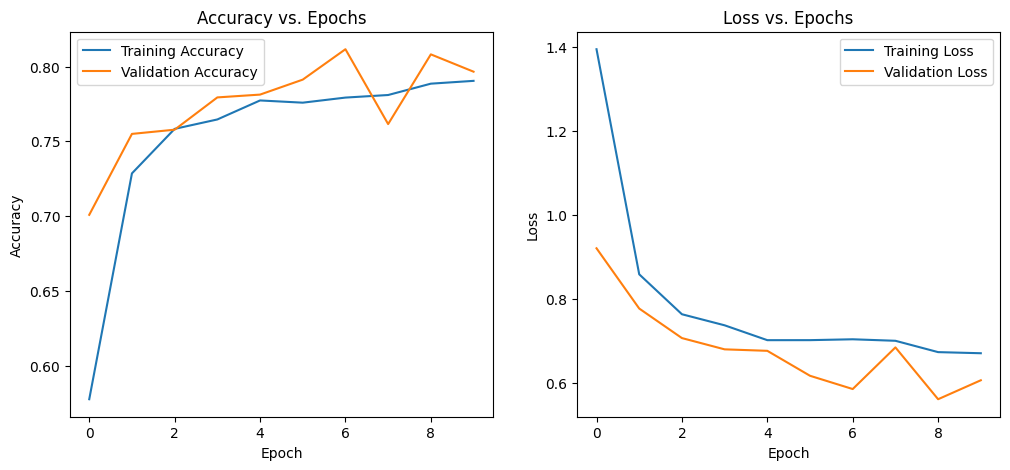

 56/100 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step

In [ ]:
if __name__ == '__main__':
    # Load datasets and class names
    train_dataset, val_dataset, test_dataset, class_names = load_datasets(SPLIT_DATASET_PATH, BATCH_SIZE, IMG_SIZE)
    num_classes = len(class_names)

    # Build the ResNet model; set fine_tune=True to unfreeze top layers after initial training if desired
    model = build_resnet_model(IMG_SIZE, num_classes, fine_tune=False)

    # Train the model with callbacks
    history = train_model(model, train_dataset, val_dataset, EPOCHS)

    # Save the model in Keras (SavedModel) format
    save_model_keras(model, MODEL_SAVE_PATH)

    # Plot training history
    plot_training_history(history)

    # Evaluate the model on the test dataset
    evaluate_model(model, test_dataset, class_names)

Test with some Example Images

In [ ]:
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels.numpy(), axis=1)

    num_images_to_show = 5
    plt.figure(figsize=(15, 3))
    for i in range(num_images_to_show):
        ax = plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        pred_class = class_names[predicted_labels[i]]
        true_class = class_names[true_labels[i]]

        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis("off")
    plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Path to your MRI image file (update this path as needed)
mri_image_path = '/content/drive/MyDrive/DSGP/Splitted_Dataset/test/no_tumour/image_1018.png'

# Load the image with the target size of 224x224
img = load_img(mri_image_path, target_size=(224, 224))
# Convert the image to a numpy array (values remain in [0, 255])
img_array = img_to_array(img)
# Expand dimensions to create a batch of size 1
img_array = np.expand_dims(img_array, axis=0)

# Display the image
plt.imshow(img)
plt.title("Input MRI Image")
plt.axis("off")
plt.show()

# Get predictions from the model (model should handle normalization internally)
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class = class_names[predicted_class_index]

print("Predicted class:", predicted_class)
